# NB03: Biogeographic Analysis of Dark Gene Carriers

**Requires BERDL JupyterHub** — `get_spark_session()` is only available in JupyterHub kernels.

## Purpose

Test whether the environmental distribution of dark gene carriers shows non-random patterns.
For accessory dark genes with strong fitness effects, compare the environments of genomes
that carry the gene vs genomes in the same species that lack it (within-species test,
controlling for phylogeny).

## Inputs

- `data/dark_genes_integrated.tsv` from NB01 — unified dark gene table
- `data/phylogenetic_breadth.tsv` from NB02 — eggNOG OG annotations

## Outputs

- `data/biogeographic_profiles.tsv` — per-species environmental profiles for target dark gene species
- `data/carrier_noncarrier_tests.tsv` — within-species carrier vs non-carrier test results
- `figures/fig08_env_distribution.png` — environment classification of carrier species
- `figures/fig09_carrier_tests.png` — within-species test results summary
- `figures/fig10_embedding_umap.png` — UMAP of carrier/non-carrier genomes

## Approach

1. Select accessory dark genes with strong fitness effects (|fit|≥2, n_very_strong>0)
2. Extract AlphaEarth embeddings + NCBI env metadata for all genomes in target species
3. Identify carrier vs non-carrier genomes per gene cluster
4. Within-species carrier vs non-carrier comparisons (Mann-Whitney U on embeddings, Fisher's exact on env categories)
5. Environmental characterization and UMAP visualization

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Path setup — robust for JupyterHub nbconvert execution
if os.path.basename(os.getcwd()) == 'notebooks':
    PROJECT_DIR = os.path.dirname(os.getcwd())
else:
    PROJECT_DIR = os.getcwd()
    _d = PROJECT_DIR
    while _d != '/':
        if os.path.exists(os.path.join(_d, 'PROJECT.md')):
            break
        _d = os.path.dirname(_d)

DATA_DIR = os.path.join(PROJECT_DIR, 'data')
FIG_DIR = os.path.join(PROJECT_DIR, 'figures')
os.makedirs(FIG_DIR, exist_ok=True)

# Spark session — injected on JupyterHub
spark = get_spark_session()

print(f'Project dir: {PROJECT_DIR}')
print(f'Data dir: {DATA_DIR}')

Project dir: /home/aparkin/BERIL-research-observatory/projects/functional_dark_matter
Data dir: /home/aparkin/BERIL-research-observatory/projects/functional_dark_matter/data


## Section 1: Load Data and Select Target Gene Families

In [2]:
# Load dark genes from NB01
dark = pd.read_csv(os.path.join(DATA_DIR, 'dark_genes_only.tsv'), sep='\t', low_memory=False)
print(f'Dark genes loaded: {len(dark):,}')
print(f'  With pangenome link: {dark["has_pangenome_link"].sum():,}')
print(f'  Accessory: {(dark["is_auxiliary"] == True).sum():,}')

# Load phylogenetic breadth from NB02
phylo = pd.read_csv(os.path.join(DATA_DIR, 'phylogenetic_breadth.tsv'), sep='\t')
print(f'Phylogenetic breadth entries: {len(phylo):,}')

Dark genes loaded: 57,011
  With pangenome link: 39,532
  Accessory: 12,686
Phylogenetic breadth entries: 30,756


In [3]:
# Select accessory dark genes with strong fitness effects
# These are genes present in some but not all genomes of a species,
# and they have |fitness| >= 2 under at least one condition with |t| > 4
targets = dark[
    (dark['is_auxiliary'] == True) &
    (dark['max_abs_fit'] >= 2) &
    (dark['n_very_strong_conditions'] > 0) &
    (dark['gene_cluster_id'].notna())
].copy()

print(f'Target accessory dark genes: {len(targets):,}')
print(f'  Unique gene clusters: {targets["gene_cluster_id"].nunique():,}')
print(f'  Unique species: {targets["gtdb_species_clade_id"].nunique():,}')
print(f'  Unique organisms (FB): {targets["orgId"].nunique():,}')

# Summary by condition class
print(f'\nTop fitness condition classes:')
print(targets['top_condition_class'].value_counts().head(10).to_string())

# Create lookup: gene_cluster_id -> (orgId, locusId, top_condition_class, max_abs_fit)
target_species = sorted(targets['gtdb_species_clade_id'].dropna().unique().tolist())
target_clusters = sorted(targets['gene_cluster_id'].dropna().unique().tolist())
print(f'\n{len(target_species)} target species, {len(target_clusters)} target clusters')

Target accessory dark genes: 511
  Unique gene clusters: 495
  Unique species: 31
  Unique organisms (FB): 35

Top fitness condition classes:
top_condition_class
stress                256
carbon source         113
nitrogen source        39
mixed community        12
motility               11
anaerobic              10
nutrient t2             9
mouse                   8
respiratory growth      7
pH                      7

31 target species, 495 target clusters


In [4]:
# Build a summary table of target clusters with their fitness metadata
cluster_meta = targets.groupby('gene_cluster_id').agg(
    orgId=('orgId', 'first'),
    locusId=('locusId', 'first'),
    desc=('desc', 'first'),
    annotation_class=('annotation_class', 'first'),
    gtdb_species_clade_id=('gtdb_species_clade_id', 'first'),
    max_abs_fit=('max_abs_fit', 'max'),
    top_condition_class=('top_condition_class', 'first'),
    top_condition_fit=('top_condition_fit', 'first'),
    n_condition_classes=('n_condition_classes', 'max'),
    in_module=('in_module', 'max'),
    module_prediction=('module_prediction', 'first'),
).reset_index()

# Merge with phylogenetic breadth info
cluster_meta = cluster_meta.merge(
    phylo[['gene_cluster_id', 'root_og', 'n_tax_levels', 'breadth_class', 'n_species']],
    on='gene_cluster_id', how='left'
)

print(f'Target cluster metadata: {len(cluster_meta)} clusters')
print(f'  With eggNOG root OG: {cluster_meta["root_og"].notna().sum()}')
print(f'  Breadth class distribution:')
print(cluster_meta['breadth_class'].value_counts().to_string())

Target cluster metadata: 495 clusters
  With eggNOG root OG: 356
  Breadth class distribution:
breadth_class
universal        354
pan-bacterial      2


## Section 2: Extract Environmental Metadata for Target Species

For all genomes in our target species, extract:
1. **AlphaEarth embeddings** (64-dim, 28% genome coverage)
2. **NCBI env metadata** (EAV format pivoted to columns)
3. **Geographic coordinates** from AlphaEarth cleaned_lat/cleaned_lon

In [5]:
# Register target species as temp view for efficient Spark joins
species_sdf = spark.createDataFrame(
    [(str(s),) for s in target_species],
    ['gtdb_species_clade_id']
)
species_sdf.createOrReplaceTempView('target_species')
print(f'Registered {len(target_species)} target species as temp view')

Registered 31 target species as temp view


In [6]:
# Get all genomes in target species
all_genomes = spark.sql("""
    SELECT g.genome_id, g.gtdb_species_clade_id, g.ncbi_biosample_id
    FROM kbase_ke_pangenome.genome g
    JOIN target_species ts ON g.gtdb_species_clade_id = ts.gtdb_species_clade_id
""").toPandas()

print(f'Total genomes in {len(target_species)} target species: {len(all_genomes):,}')
print(f'Genomes per species (median): {all_genomes.groupby("gtdb_species_clade_id").size().median():.0f}')
print(f'Genomes per species (range): {all_genomes.groupby("gtdb_species_clade_id").size().min()} - {all_genomes.groupby("gtdb_species_clade_id").size().max()}')

Total genomes in 31 target species: 1,380
Genomes per species (median): 9
Genomes per species (range): 2 - 399


In [7]:
# Extract AlphaEarth embeddings for target species genomes
# AlphaEarth is small (83K rows) — safe to scan and filter in pandas
emb_cols_str = ', '.join([f'ae.A{i:02d}' for i in range(64)])

embeddings = spark.sql(f"""
    SELECT ae.genome_id, g.gtdb_species_clade_id,
           ae.cleaned_lat, ae.cleaned_lon,
           {emb_cols_str}
    FROM kbase_ke_pangenome.alphaearth_embeddings_all_years ae
    JOIN kbase_ke_pangenome.genome g ON ae.genome_id = g.genome_id
    JOIN target_species ts ON g.gtdb_species_clade_id = ts.gtdb_species_clade_id
""").toPandas()

emb_cols = [f'A{i:02d}' for i in range(64)]

# Filter out rows with NaN embeddings
valid_emb = ~embeddings[emb_cols].isna().any(axis=1)
n_nan = (~valid_emb).sum()
embeddings = embeddings[valid_emb]

print(f'AlphaEarth embeddings for target species: {len(embeddings):,} genomes')
print(f'  Removed {n_nan} with NaN embeddings')
emb_coverage = len(embeddings) / len(all_genomes) * 100 if len(all_genomes) > 0 else 0
print(f'  Coverage: {emb_coverage:.1f}% of genomes in target species')
print(f'  Species with embeddings: {embeddings["gtdb_species_clade_id"].nunique()}')
print(f'  Lat range: [{embeddings["cleaned_lat"].min():.1f}, {embeddings["cleaned_lat"].max():.1f}]')
print(f'  Lon range: [{embeddings["cleaned_lon"].min():.1f}, {embeddings["cleaned_lon"].max():.1f}]')

AlphaEarth embeddings for target species: 358 genomes
  Removed 5 with NaN embeddings
  Coverage: 25.9% of genomes in target species
  Species with embeddings: 26
  Lat range: [-37.8, 59.3]
  Lon range: [-122.5, 151.8]


In [8]:
# Extract NCBI environment metadata (EAV pivot) for target species genomes
# Join genome -> ncbi_env via ncbi_biosample_id = accession
# Register genome IDs as temp view for efficient join
genome_ids_sdf = spark.createDataFrame(
    [(str(gid), str(bs)) for gid, bs in zip(
        all_genomes['genome_id'].tolist(), 
        all_genomes['ncbi_biosample_id'].fillna('').tolist()
    ) if bs],
    ['genome_id', 'accession']
)
genome_ids_sdf.createOrReplaceTempView('target_genomes')

env_data = spark.sql("""
    SELECT tg.genome_id,
           MAX(CASE WHEN ne.harmonized_name = 'isolation_source' THEN ne.content END) as isolation_source,
           MAX(CASE WHEN ne.harmonized_name = 'env_broad_scale' THEN ne.content END) as env_broad_scale,
           MAX(CASE WHEN ne.harmonized_name = 'env_local_scale' THEN ne.content END) as env_local_scale,
           MAX(CASE WHEN ne.harmonized_name = 'env_medium' THEN ne.content END) as env_medium,
           MAX(CASE WHEN ne.harmonized_name = 'host' THEN ne.content END) as host,
           MAX(CASE WHEN ne.harmonized_name = 'geo_loc_name' THEN ne.content END) as geo_loc_name
    FROM target_genomes tg
    JOIN kbase_ke_pangenome.ncbi_env ne ON tg.accession = ne.accession
    GROUP BY tg.genome_id
""").toPandas()

print(f'NCBI env metadata for {len(env_data):,} genomes ({len(env_data)/len(all_genomes)*100:.1f}% coverage)')
print(f'\nField coverage:')
for col in ['isolation_source', 'env_broad_scale', 'env_local_scale', 'env_medium', 'host', 'geo_loc_name']:
    n = env_data[col].notna().sum()
    print(f'  {col}: {n:,} ({n/len(env_data)*100:.1f}%)')

NCBI env metadata for 1,380 genomes (100.0% coverage)

Field coverage:
  isolation_source: 914 (66.2%)
  env_broad_scale: 511 (37.0%)
  env_local_scale: 442 (32.0%)
  env_medium: 439 (31.8%)
  host: 932 (67.5%)
  geo_loc_name: 1,320 (95.7%)


In [9]:
# Classify environments using keyword-based scheme
# (following phb_granule_ecology and env_embedding_explorer patterns)
def classify_environment(row):
    """Classify genome environment from NCBI metadata into broad categories."""
    source = str(row.get('isolation_source', '')).lower()
    host = str(row.get('host', '')).lower()
    env_broad = str(row.get('env_broad_scale', '')).lower()
    
    # Contaminated / industrial
    if any(kw in source for kw in ['contaminated', 'polluted', 'mining', 'acid mine',
                                    'industrial', 'heavy metal', 'uranium', 'chromium']):
        return 'contaminated'
    
    # Human/clinical
    if any(kw in source for kw in ['blood', 'sputum', 'urine', 'wound', 'clinical',
                                    'patient', 'hospital', 'human']):
        return 'human_clinical'
    if 'homo sapiens' in host or 'human' in host:
        return 'human_associated'
    
    # Animal-associated
    if any(kw in source for kw in ['animal', 'bovine', 'chicken', 'pig', 'cattle',
                                    'poultry', 'feces', 'gut', 'intestin', 'rumen']):
        return 'animal_associated'
    
    # Soil / rhizosphere
    if any(kw in source for kw in ['soil', 'rhizosphere', 'root', 'compost', 'peat',
                                    'agricultural', 'sediment']):
        return 'soil_sediment'
    
    # Marine / saline
    if any(kw in source for kw in ['marine', 'ocean', 'sea', 'seawater', 'coastal',
                                    'saline', 'brackish', 'salt', 'brine', 'hypersaline']):
        return 'marine_saline'
    
    # Freshwater
    if any(kw in source for kw in ['freshwater', 'lake', 'river', 'pond', 'stream',
                                    'groundwater', 'spring', 'aquifer']):
        return 'freshwater'
    
    # Plant-associated
    if any(kw in source for kw in ['plant', 'leaf', 'stem', 'flower', 'seed',
                                    'phyllosphere', 'endophyte']):
        return 'plant_associated'
    
    # Wastewater / engineered
    if any(kw in source for kw in ['wastewater', 'sewage', 'activated sludge',
                                    'bioreactor', 'ferment']):
        return 'wastewater_engineered'
    
    # Extreme environments
    if any(kw in source for kw in ['hot spring', 'hydrothermal', 'volcanic',
                                    'permafrost', 'acidic', 'alkaline']):
        return 'extreme'
    
    return 'other_unknown'

env_data['env_category'] = env_data.apply(classify_environment, axis=1)
print('Environment classification:')
print(env_data['env_category'].value_counts().to_string())

Environment classification:
env_category
other_unknown            589
human_associated         430
human_clinical           144
soil_sediment             69
freshwater                67
animal_associated         29
plant_associated          28
wastewater_engineered     13
marine_saline              8
contaminated               3


## Section 3: Identify Carrier vs Non-Carrier Genomes

For each target gene cluster, determine which genomes in its species carry the gene.

The `gene_cluster` table (132M rows) has one row per cluster (cluster-level attributes) but no `genome_id`.
To find which genomes carry each cluster, we need:
1. `gene_genecluster_junction` (1B rows): gene_id → gene_cluster_id
2. `gene` (1B rows): gene_id → genome_id

We use a two-step approach with temp views to keep joins efficient:
- Step 1: Filter junction table by our 495 target cluster IDs (broadcast join)
- Step 2: Look up genome_ids for the matching gene_ids

In [10]:
# Register target clusters as temp view
clusters_sdf = spark.createDataFrame(
    [(str(c),) for c in target_clusters],
    ['gene_cluster_id']
)
clusters_sdf.createOrReplaceTempView('target_clusters')

# Step 1: Find gene_ids belonging to our target clusters
# gene_genecluster_junction has 1B rows but we broadcast our small 495-cluster list
print(f'Step 1: Querying gene_genecluster_junction for {len(target_clusters)} target clusters...')
print('  (scanning 1B-row junction table with broadcast filter — may take a few minutes)')

target_genes_sdf = spark.sql("""
    SELECT /*+ BROADCAST(tc) */
           j.gene_id, j.gene_cluster_id
    FROM kbase_ke_pangenome.gene_genecluster_junction j
    JOIN target_clusters tc ON j.gene_cluster_id = tc.gene_cluster_id
""")
target_genes_sdf.createOrReplaceTempView('target_genes')

# Cache and count to trigger the computation
target_genes_sdf.cache()
n_target_genes = target_genes_sdf.count()
print(f'  Found {n_target_genes:,} gene-cluster pairs')

# Step 2: Look up genome_ids for those genes
# gene table has 1B rows but we broadcast our smaller target_genes view
print(f'Step 2: Looking up genome_ids for {n_target_genes:,} genes...')

carrier_genomes = spark.sql("""
    SELECT /*+ BROADCAST(tg) */
           DISTINCT tg.gene_cluster_id, g.genome_id
    FROM target_genes tg
    JOIN kbase_ke_pangenome.gene g ON tg.gene_id = g.gene_id
""").toPandas()

print(f'Carrier genome-cluster pairs: {len(carrier_genomes):,}')
print(f'  Unique clusters with carriers: {carrier_genomes["gene_cluster_id"].nunique():,}')
print(f'  Unique carrier genomes: {carrier_genomes["genome_id"].nunique():,}')

# Clean up cache
target_genes_sdf.unpersist()

Step 1: Querying gene_genecluster_junction for 495 target clusters...
  (scanning 1B-row junction table with broadcast filter — may take a few minutes)


  Found 8,176 gene-cluster pairs
Step 2: Looking up genome_ids for 8,176 genes...


Carrier genome-cluster pairs: 8,139
  Unique clusters with carriers: 495
  Unique carrier genomes: 992


DataFrame[gene_id: string, gene_cluster_id: string]

In [11]:
# For each cluster, compute carrier/non-carrier counts within its species
# Merge cluster -> species mapping
cluster_species = cluster_meta[['gene_cluster_id', 'gtdb_species_clade_id']].copy()
genomes_per_species = all_genomes.groupby('gtdb_species_clade_id')['genome_id'].apply(set).to_dict()

# Build carrier sets per cluster
carrier_sets = carrier_genomes.groupby('gene_cluster_id')['genome_id'].apply(set).to_dict()

# Compute per-cluster carrier stats
cluster_stats = []
for _, row in cluster_species.iterrows():
    cid = row['gene_cluster_id']
    sid = row['gtdb_species_clade_id']
    
    all_gids = genomes_per_species.get(sid, set())
    carrier_gids = carrier_sets.get(cid, set()) & all_gids  # carriers within this species
    noncarrier_gids = all_gids - carrier_gids
    
    cluster_stats.append({
        'gene_cluster_id': cid,
        'gtdb_species_clade_id': sid,
        'n_total': len(all_gids),
        'n_carriers': len(carrier_gids),
        'n_noncarriers': len(noncarrier_gids),
        'carrier_fraction': len(carrier_gids) / len(all_gids) if all_gids else 0,
    })

cluster_stats_df = pd.DataFrame(cluster_stats)

print(f'Cluster carrier statistics:')
print(f'  Total clusters: {len(cluster_stats_df)}')
print(f'  Carrier fraction: median={cluster_stats_df["carrier_fraction"].median():.3f}, '
      f'mean={cluster_stats_df["carrier_fraction"].mean():.3f}')
print(f'\n  Carrier count distribution:')
print(cluster_stats_df['n_carriers'].describe().to_string())

# Filter: need >= 5 carriers AND >= 5 non-carriers for meaningful comparison
testable = cluster_stats_df[
    (cluster_stats_df['n_carriers'] >= 5) &
    (cluster_stats_df['n_noncarriers'] >= 5)
]
print(f'\nTestable clusters (>=5 carriers AND >=5 non-carriers): {len(testable)}')

Cluster carrier statistics:
  Total clusters: 495
  Carrier fraction: median=0.333, mean=0.357

  Carrier count distribution:
count    495.000000
mean      16.442424
std       37.773995
min        1.000000
25%        1.500000
50%        3.000000
75%        8.500000
max      243.000000

Testable clusters (>=5 carriers AND >=5 non-carriers): 151


## Section 4: Within-Species Carrier vs Non-Carrier Tests

For each testable cluster:
1. **Embedding test**: Mann-Whitney U on mean embedding distance between carrier and non-carrier genomes
2. **Environment category test**: Fisher's exact test on environment classification frequencies

These within-species comparisons control for phylogenetic confounding.

In [12]:
# Build genome-level lookups for embeddings and env data
emb_lookup = embeddings.set_index('genome_id')[emb_cols]
env_lookup = env_data.set_index('genome_id')['env_category']

print(f'Embedding lookup: {len(emb_lookup):,} genomes')
print(f'Env category lookup: {len(env_lookup):,} genomes')

Embedding lookup: 358 genomes
Env category lookup: 1,380 genomes


In [13]:
# Run within-species tests
results = []
testable_ids = testable['gene_cluster_id'].tolist()

for i, cid in enumerate(testable_ids):
    row = cluster_stats_df[cluster_stats_df['gene_cluster_id'] == cid].iloc[0]
    sid = row['gtdb_species_clade_id']
    all_gids = genomes_per_species.get(sid, set())
    carrier_gids = carrier_sets.get(cid, set()) & all_gids
    noncarrier_gids = all_gids - carrier_gids
    
    res = {
        'gene_cluster_id': cid,
        'gtdb_species_clade_id': sid,
        'n_carriers': len(carrier_gids),
        'n_noncarriers': len(noncarrier_gids),
    }
    
    # --- Embedding test ---
    carrier_emb_ids = [g for g in carrier_gids if g in emb_lookup.index]
    noncarrier_emb_ids = [g for g in noncarrier_gids if g in emb_lookup.index]
    res['n_carriers_with_emb'] = len(carrier_emb_ids)
    res['n_noncarriers_with_emb'] = len(noncarrier_emb_ids)
    
    if len(carrier_emb_ids) >= 3 and len(noncarrier_emb_ids) >= 3:
        carrier_vecs = emb_lookup.loc[carrier_emb_ids].values
        noncarrier_vecs = emb_lookup.loc[noncarrier_emb_ids].values
        
        # Compute L2 norm of each genome's embedding (proxy for environmental signal strength)
        carrier_norms = np.linalg.norm(carrier_vecs, axis=1)
        noncarrier_norms = np.linalg.norm(noncarrier_vecs, axis=1)
        
        # Also compute centroid distance between carrier/non-carrier groups
        carrier_centroid = carrier_vecs.mean(axis=0)
        noncarrier_centroid = noncarrier_vecs.mean(axis=0)
        centroid_dist = np.linalg.norm(carrier_centroid - noncarrier_centroid)
        
        # Compute per-dimension variance to find which dimensions differ most
        carrier_var = carrier_vecs.var(axis=0).sum()
        noncarrier_var = noncarrier_vecs.var(axis=0).sum()
        
        # Mann-Whitney U on L2 norms
        try:
            u_stat, p_emb = stats.mannwhitneyu(carrier_norms, noncarrier_norms, alternative='two-sided')
        except ValueError:
            u_stat, p_emb = np.nan, np.nan
        
        res['emb_centroid_dist'] = centroid_dist
        res['emb_carrier_var'] = carrier_var
        res['emb_noncarrier_var'] = noncarrier_var
        res['emb_u_stat'] = u_stat
        res['emb_p_value'] = p_emb
    else:
        res['emb_centroid_dist'] = np.nan
        res['emb_carrier_var'] = np.nan
        res['emb_noncarrier_var'] = np.nan
        res['emb_u_stat'] = np.nan
        res['emb_p_value'] = np.nan
    
    # --- Environment category test ---
    carrier_env = [env_lookup.get(g, 'no_data') for g in carrier_gids if g in env_lookup.index]
    noncarrier_env = [env_lookup.get(g, 'no_data') for g in noncarrier_gids if g in env_lookup.index]
    res['n_carriers_with_env'] = len(carrier_env)
    res['n_noncarriers_with_env'] = len(noncarrier_env)
    
    if len(carrier_env) >= 3 and len(noncarrier_env) >= 3:
        # Find most common carrier env category (excluding other_unknown)
        carrier_counts = pd.Series(carrier_env).value_counts()
        meaningful_cats = [c for c in carrier_counts.index if c not in ('other_unknown', 'no_data')]
        
        if meaningful_cats:
            top_carrier_env = meaningful_cats[0]
            # 2x2 table: (carrier/noncarrier) x (top_env / other)
            a = sum(1 for e in carrier_env if e == top_carrier_env)
            b = sum(1 for e in carrier_env if e != top_carrier_env)
            c = sum(1 for e in noncarrier_env if e == top_carrier_env)
            d = sum(1 for e in noncarrier_env if e != top_carrier_env)
            
            if a + c > 0:  # at least some genomes in top category
                odds_ratio, p_env = stats.fisher_exact([[a, b], [c, d]])
                res['top_carrier_env'] = top_carrier_env
                res['env_odds_ratio'] = odds_ratio
                res['env_p_value'] = p_env
                res['env_carrier_pct'] = a / (a + b) * 100 if (a + b) > 0 else 0
                res['env_noncarrier_pct'] = c / (c + d) * 100 if (c + d) > 0 else 0
            else:
                res['top_carrier_env'] = top_carrier_env
                res['env_odds_ratio'] = np.nan
                res['env_p_value'] = np.nan
                res['env_carrier_pct'] = np.nan
                res['env_noncarrier_pct'] = np.nan
        else:
            res['top_carrier_env'] = 'other_unknown'
            res['env_odds_ratio'] = np.nan
            res['env_p_value'] = np.nan
            res['env_carrier_pct'] = np.nan
            res['env_noncarrier_pct'] = np.nan
    else:
        res['top_carrier_env'] = np.nan
        res['env_odds_ratio'] = np.nan
        res['env_p_value'] = np.nan
        res['env_carrier_pct'] = np.nan
        res['env_noncarrier_pct'] = np.nan
    
    results.append(res)
    
    if (i + 1) % 50 == 0:
        print(f'  Processed {i+1}/{len(testable_ids)} clusters')

results_df = pd.DataFrame(results)
print(f'\nCarrier vs non-carrier tests completed: {len(results_df)} clusters')
print(f'  With embedding test: {results_df["emb_p_value"].notna().sum()}')
print(f'  With env category test: {results_df["env_p_value"].notna().sum()}')

  Processed 50/151 clusters


  Processed 100/151 clusters


  Processed 150/151 clusters

Carrier vs non-carrier tests completed: 151 clusters
  With embedding test: 67
  With env category test: 137


In [14]:
# Apply BH-FDR correction
from statsmodels.stats.multitest import multipletests

# Embedding tests
emb_mask = results_df['emb_p_value'].notna()
if emb_mask.sum() > 0:
    _, emb_fdr, _, _ = multipletests(results_df.loc[emb_mask, 'emb_p_value'], method='fdr_bh')
    results_df.loc[emb_mask, 'emb_fdr'] = emb_fdr
    n_sig_emb = (emb_fdr < 0.05).sum()
    print(f'Embedding tests: {emb_mask.sum()} tested, {n_sig_emb} significant (FDR < 0.05)')
else:
    results_df['emb_fdr'] = np.nan
    print('No embedding tests could be run')

# Environment category tests
env_mask = results_df['env_p_value'].notna()
if env_mask.sum() > 0:
    _, env_fdr, _, _ = multipletests(results_df.loc[env_mask, 'env_p_value'], method='fdr_bh')
    results_df.loc[env_mask, 'env_fdr'] = env_fdr
    n_sig_env = (env_fdr < 0.05).sum()
    print(f'Env category tests: {env_mask.sum()} tested, {n_sig_env} significant (FDR < 0.05)')
else:
    results_df['env_fdr'] = np.nan
    print('No environment category tests could be run')

Embedding tests: 67 tested, 1 significant (FDR < 0.05)
Env category tests: 137 tested, 9 significant (FDR < 0.05)


In [15]:
# Merge test results with cluster metadata
results_full = results_df.merge(
    cluster_meta[['gene_cluster_id', 'orgId', 'locusId', 'desc', 'annotation_class',
                  'max_abs_fit', 'top_condition_class', 'top_condition_fit',
                  'root_og', 'breadth_class', 'in_module', 'module_prediction']],
    on='gene_cluster_id', how='left'
)

# Show top results by embedding centroid distance
sig_emb = results_full[results_full['emb_fdr'].notna() & (results_full['emb_fdr'] < 0.2)]
if len(sig_emb) > 0:
    print(f'Clusters with embedding FDR < 0.2: {len(sig_emb)}')
    cols = ['gene_cluster_id', 'orgId', 'locusId', 'desc', 'top_condition_class',
            'max_abs_fit', 'n_carriers', 'n_noncarriers',
            'emb_centroid_dist', 'emb_p_value', 'emb_fdr']
    print(sig_emb.sort_values('emb_centroid_dist', ascending=False)[cols].head(20).to_string())
else:
    print('No clusters with FDR < 0.2 for embedding test')
    print('\nTop 10 by centroid distance (regardless of significance):')
    cols = ['gene_cluster_id', 'orgId', 'desc', 'top_condition_class',
            'n_carriers', 'n_noncarriers', 'n_carriers_with_emb', 'n_noncarriers_with_emb',
            'emb_centroid_dist', 'emb_p_value']
    top_emb = results_full[results_full['emb_p_value'].notna()].sort_values('emb_centroid_dist', ascending=False)
    print(top_emb[cols].head(10).to_string())

Clusters with embedding FDR < 0.2: 3
              gene_cluster_id          orgId    locusId                                desc top_condition_class  max_abs_fit  n_carriers  n_noncarriers  emb_centroid_dist  emb_p_value   emb_fdr
97    NZ_JAKMVM010000001.1_34  SyringaeB728a  Psyr_1935  Protein of unknown function DUF796              stress     2.442271          33             93           0.543195     0.000484  0.032446
99   NZ_JAKMVQ010000003.1_215  SyringaeB728a  Psyr_2805                hypothetical protein              stress     3.435206          31             95           0.352681     0.002695  0.072638
114     NZ_LKCE01000001.1_584  SyringaeB728a  Psyr_2816                hypothetical protein              stress     2.595470          41             85           0.295728     0.003252  0.072638


In [16]:
# Show top results by environment category enrichment
sig_env = results_full[results_full['env_fdr'].notna() & (results_full['env_fdr'] < 0.2)]
if len(sig_env) > 0:
    print(f'Clusters with env category FDR < 0.2: {len(sig_env)}')
    cols = ['gene_cluster_id', 'orgId', 'locusId', 'desc', 'top_condition_class',
            'max_abs_fit', 'top_carrier_env', 'env_odds_ratio',
            'env_carrier_pct', 'env_noncarrier_pct', 'env_p_value', 'env_fdr']
    print(sig_env.sort_values('env_odds_ratio', ascending=False)[cols].head(20).to_string())
else:
    print('No clusters with FDR < 0.2 for env category test')
    print('\nTop 10 by odds ratio (regardless of significance):')
    cols = ['gene_cluster_id', 'orgId', 'desc', 'top_condition_class',
            'top_carrier_env', 'env_odds_ratio', 'env_p_value',
            'n_carriers_with_env', 'n_noncarriers_with_env']
    top_env = results_full[results_full['env_odds_ratio'].notna()].sort_values('env_odds_ratio', ascending=False)
    print(top_env[cols].head(10).to_string())

Clusters with env category FDR < 0.2: 26
               gene_cluster_id                    orgId      locusId                                                                                                     desc top_condition_class  max_abs_fit   top_carrier_env  env_odds_ratio  env_carrier_pct  env_noncarrier_pct   env_p_value   env_fdr
63     NZ_JACVAH010000015.1_20           pseudo5_N2C3_1  AO356_12450                                                                                     hypothetical protein       carbon source     2.076086        freshwater             inf        50.000000            0.000000  2.941176e-02  0.191877
34          NZ_CP012831.1_2249           pseudo5_N2C3_1  AO356_11255                                                                                     hypothetical protein     nitrogen source     3.359544        freshwater             inf        80.000000            0.000000  2.100840e-03  0.031979
145        NZ_WKBX01000256.1_7            SyringaeB72

## Section 5: Environmental Characterization and Visualization

In [17]:
# Build species-level biogeographic profile
# For each target species, summarize the environment of its genomes
species_profiles = []
for sid in target_species:
    gids = genomes_per_species.get(sid, set())
    if not gids:
        continue
    
    # Env category breakdown
    sp_env = env_data[env_data['genome_id'].isin(gids)]
    sp_emb = embeddings[embeddings['gtdb_species_clade_id'] == sid]
    
    env_counts = sp_env['env_category'].value_counts()
    primary_env = env_counts.index[0] if len(env_counts) > 0 else 'no_data'
    
    # Number of dark gene clusters in this species
    sp_clusters = cluster_meta[cluster_meta['gtdb_species_clade_id'] == sid]
    
    species_profiles.append({
        'gtdb_species_clade_id': sid,
        'n_genomes': len(gids),
        'n_with_env': len(sp_env),
        'n_with_emb': len(sp_emb),
        'primary_env': primary_env,
        'n_env_categories': sp_env['env_category'].nunique() if len(sp_env) > 0 else 0,
        'n_dark_clusters': len(sp_clusters),
        'median_lat': sp_emb['cleaned_lat'].median() if len(sp_emb) > 0 else np.nan,
        'median_lon': sp_emb['cleaned_lon'].median() if len(sp_emb) > 0 else np.nan,
    })

profiles_df = pd.DataFrame(species_profiles)
print(f'Species biogeographic profiles: {len(profiles_df)}')
print(f'\nPrimary environment distribution:')
print(profiles_df['primary_env'].value_counts().to_string())
print(f'\nEmbedding coverage: {(profiles_df["n_with_emb"] > 0).sum()} / {len(profiles_df)} species')

Species biogeographic profiles: 31

Primary environment distribution:
primary_env
other_unknown       22
soil_sediment        5
human_associated     3
freshwater           1

Embedding coverage: 26 / 31 species


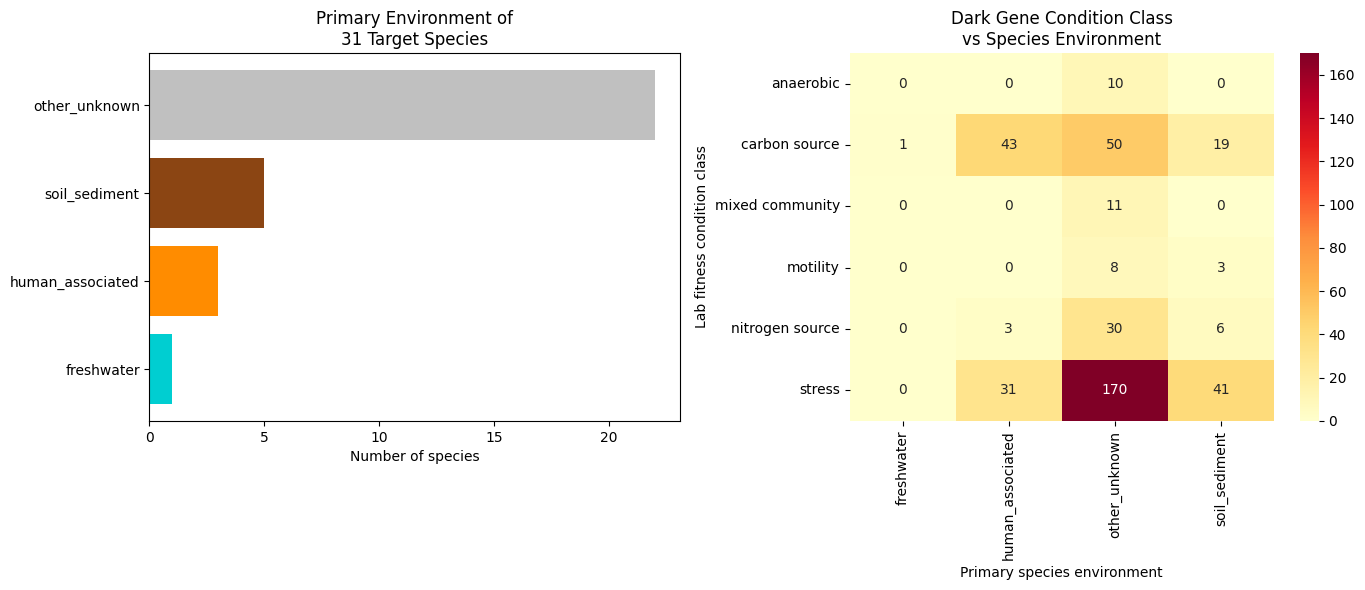

Saved fig08_env_distribution.png


In [18]:
# Figure 8: Environment distribution of dark gene carrier species
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel A: Environment classification of target species
ax = axes[0]
env_order = profiles_df['primary_env'].value_counts()
colors_map = {
    'soil_sediment': '#8B4513', 'marine_saline': '#1E90FF', 'freshwater': '#00CED1',
    'human_clinical': '#FF6347', 'human_associated': '#FF8C00', 'animal_associated': '#DDA0DD',
    'contaminated': '#808080', 'plant_associated': '#32CD32', 'extreme': '#FF4500',
    'wastewater_engineered': '#9370DB', 'other_unknown': '#C0C0C0'
}
bar_colors = [colors_map.get(e, '#C0C0C0') for e in env_order.index]
ax.barh(range(len(env_order)), env_order.values, color=bar_colors)
ax.set_yticks(range(len(env_order)))
ax.set_yticklabels(env_order.index)
ax.set_xlabel('Number of species')
ax.set_title(f'Primary Environment of\n{len(profiles_df)} Target Species')
ax.invert_yaxis()

# Panel B: Condition class vs environment for dark genes
ax = axes[1]
# Merge cluster condition classes with species environments
cond_env = cluster_meta.merge(
    profiles_df[['gtdb_species_clade_id', 'primary_env']],
    on='gtdb_species_clade_id', how='left'
)
ct = pd.crosstab(cond_env['top_condition_class'], cond_env['primary_env'])
# Keep top 6 conditions and top 6 environments
top_conds = cond_env['top_condition_class'].value_counts().head(6).index.tolist()
top_envs = cond_env['primary_env'].value_counts().head(6).index.tolist()
ct_sub = ct.loc[ct.index.isin(top_conds), ct.columns.isin(top_envs)]
if len(ct_sub) > 0:
    sns.heatmap(ct_sub, annot=True, fmt='d', cmap='YlOrRd', ax=ax)
    ax.set_title('Dark Gene Condition Class\nvs Species Environment')
    ax.set_xlabel('Primary species environment')
    ax.set_ylabel('Lab fitness condition class')
else:
    ax.text(0.5, 0.5, 'Insufficient data for heatmap', ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'fig08_env_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved fig08_env_distribution.png')

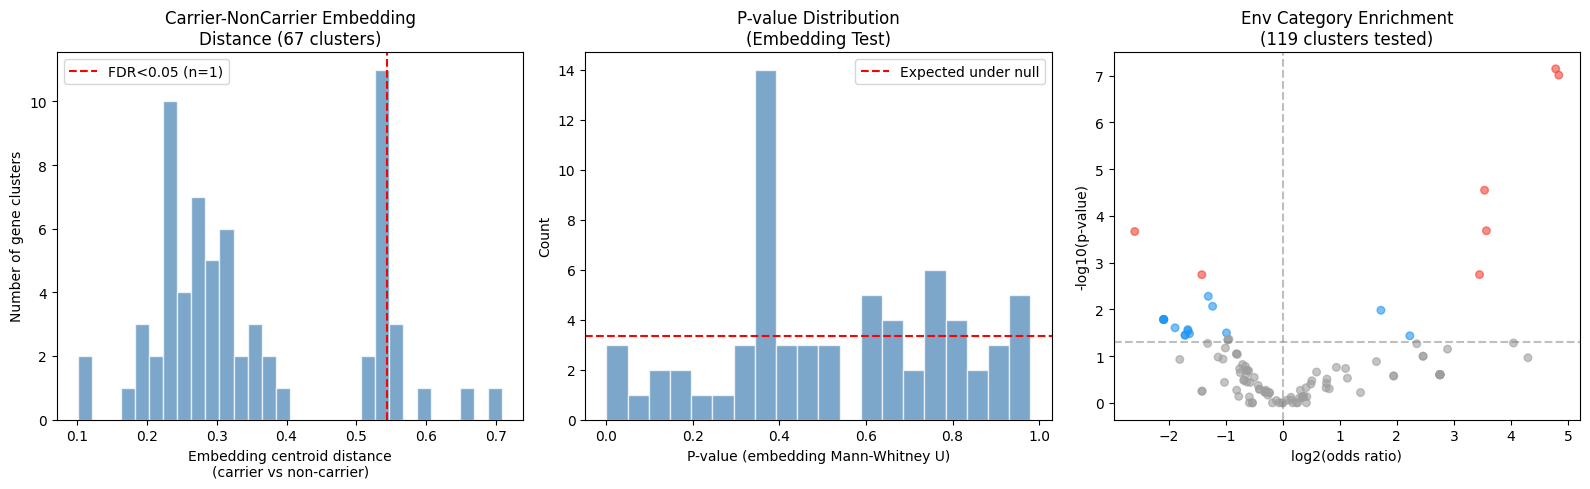

Saved fig09_carrier_tests.png


In [19]:
# Figure 9: Carrier vs non-carrier test results summary
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Panel A: Distribution of embedding centroid distances
ax = axes[0]
valid = results_full[results_full['emb_centroid_dist'].notna()]
if len(valid) > 0:
    ax.hist(valid['emb_centroid_dist'], bins=30, color='steelblue', alpha=0.7, edgecolor='white')
    ax.set_xlabel('Embedding centroid distance\n(carrier vs non-carrier)')
    ax.set_ylabel('Number of gene clusters')
    ax.set_title(f'Carrier-NonCarrier Embedding\nDistance ({len(valid)} clusters)')
    if 'emb_fdr' in valid.columns:
        n_sig = (valid['emb_fdr'] < 0.05).sum()
        ax.axvline(valid.loc[valid['emb_fdr'] < 0.05, 'emb_centroid_dist'].min() if n_sig > 0 else 999,
                   color='red', linestyle='--', label=f'FDR<0.05 (n={n_sig})')
        ax.legend()

# Panel B: P-value distribution (embedding test)
ax = axes[1]
emb_pvals = results_full['emb_p_value'].dropna()
if len(emb_pvals) > 0:
    ax.hist(emb_pvals, bins=20, color='steelblue', alpha=0.7, edgecolor='white')
    ax.axhline(len(emb_pvals) / 20, color='red', linestyle='--', label='Expected under null')
    ax.set_xlabel('P-value (embedding Mann-Whitney U)')
    ax.set_ylabel('Count')
    ax.set_title('P-value Distribution\n(Embedding Test)')
    ax.legend()

# Panel C: Env category odds ratios
ax = axes[2]
env_or = results_full[results_full['env_odds_ratio'].notna() & np.isfinite(results_full['env_odds_ratio'])]
if len(env_or) > 0:
    log_or = np.log2(env_or['env_odds_ratio'].clip(lower=0.01))
    colors = ['#F44336' if fdr < 0.05 else '#2196F3' if fdr < 0.2 else '#9E9E9E'
              for fdr in env_or.get('env_fdr', [1]*len(env_or))]
    ax.scatter(log_or, -np.log10(env_or['env_p_value'].clip(lower=1e-20)),
              c=colors, alpha=0.6, s=30)
    ax.axhline(-np.log10(0.05), color='gray', linestyle='--', alpha=0.5)
    ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('log2(odds ratio)')
    ax.set_ylabel('-log10(p-value)')
    ax.set_title(f'Env Category Enrichment\n({len(env_or)} clusters tested)')

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'fig09_carrier_tests.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved fig09_carrier_tests.png')

/opt/conda/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


/opt/conda/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/conda/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


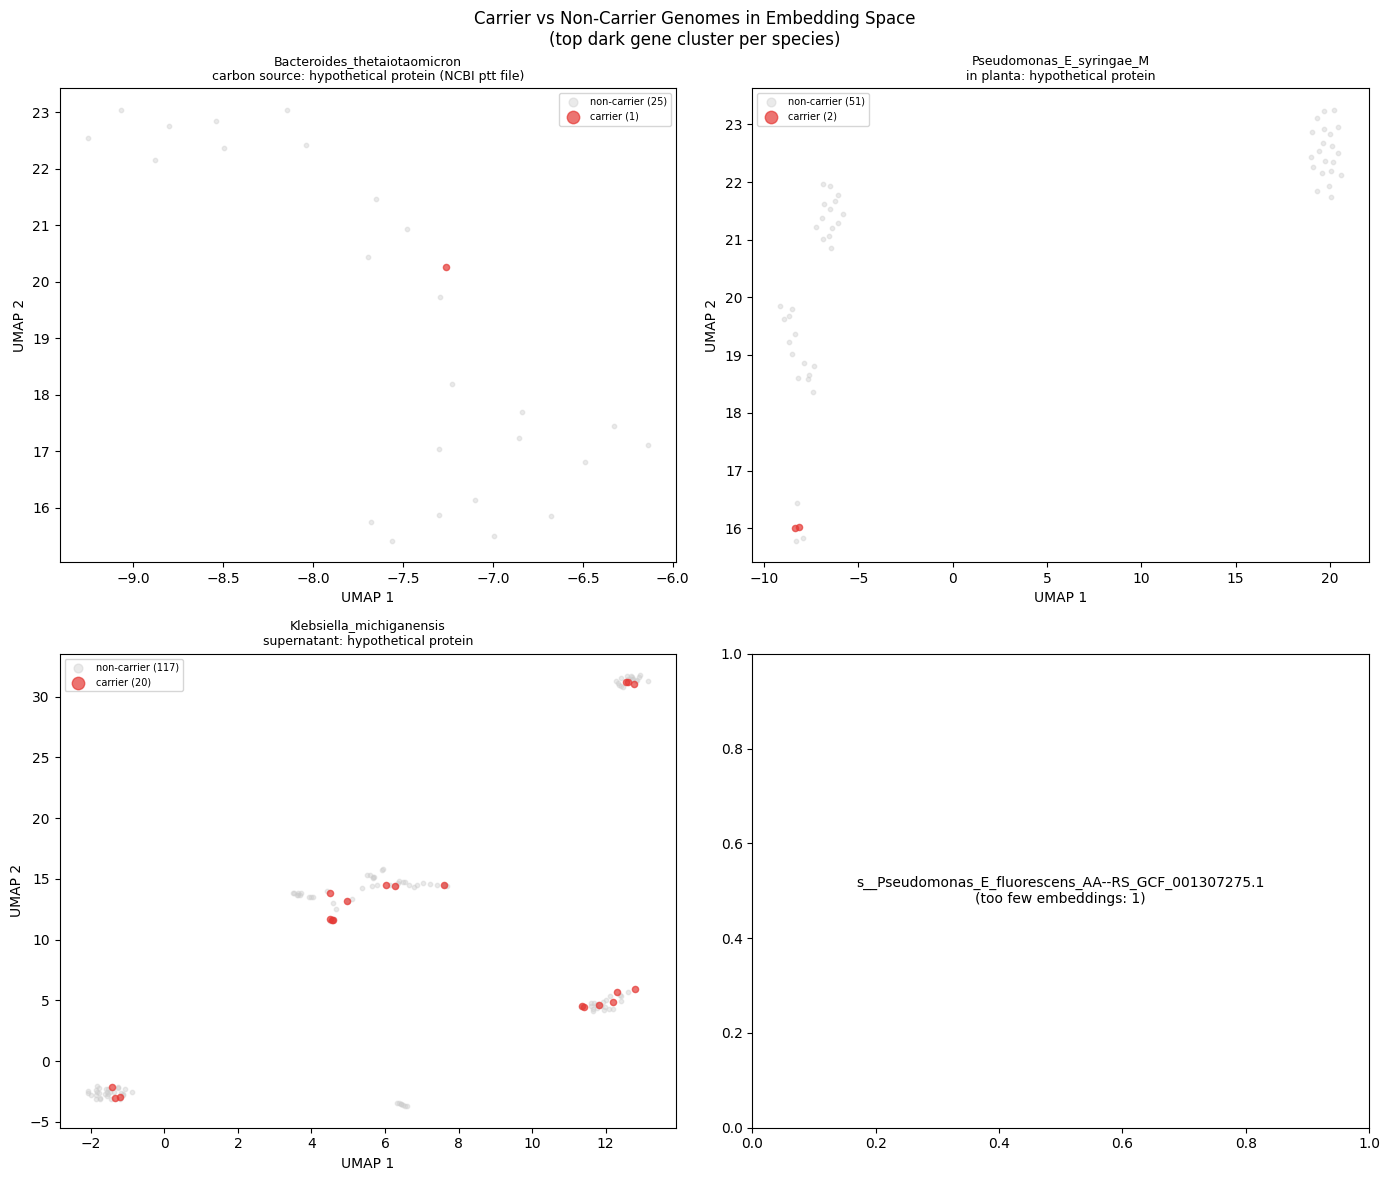

Saved fig10_embedding_umap.png


In [20]:
# Figure 10: UMAP of embeddings for top species, colored by carrier status
# Select species with most testable clusters and decent embedding coverage
try:
    from sklearn.manifold import TSNE
    HAS_SKLEARN = True
except ImportError:
    HAS_SKLEARN = False

try:
    import umap
    HAS_UMAP = True
except ImportError:
    HAS_UMAP = False

# Pick top 4 species by number of testable clusters
species_cluster_counts = testable.groupby('gtdb_species_clade_id').size().sort_values(ascending=False)
top4_species = species_cluster_counts.head(4).index.tolist()

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for idx, sid in enumerate(top4_species):
    ax = axes[idx // 2][idx % 2]
    
    # Get embeddings for this species
    sp_emb = embeddings[embeddings['gtdb_species_clade_id'] == sid]
    
    if len(sp_emb) < 10:
        ax.text(0.5, 0.5, f'{sid}\n(too few embeddings: {len(sp_emb)})',
                ha='center', va='center', transform=ax.transAxes)
        continue
    
    # Get the top cluster for this species (strongest fitness effect)
    sp_clusters = cluster_meta[cluster_meta['gtdb_species_clade_id'] == sid].sort_values('max_abs_fit', ascending=False)
    if len(sp_clusters) == 0:
        continue
    top_cluster = sp_clusters.iloc[0]['gene_cluster_id']
    top_desc = sp_clusters.iloc[0]['desc']
    top_cond = sp_clusters.iloc[0]['top_condition_class']
    
    # Carrier status for this cluster
    carrier_gids_here = carrier_sets.get(top_cluster, set())
    sp_emb = sp_emb.copy()
    sp_emb['is_carrier'] = sp_emb['genome_id'].isin(carrier_gids_here)
    
    X = sp_emb[emb_cols].values
    
    # Dimensionality reduction
    if HAS_UMAP and len(X) >= 15:
        n_neighbors = min(15, len(X) - 1)
        reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=0.1, random_state=42)
        coords = reducer.fit_transform(X)
        method = 'UMAP'
    elif HAS_SKLEARN and len(X) >= 10:
        perp = min(30, len(X) - 1)
        coords = TSNE(n_components=2, perplexity=perp, random_state=42).fit_transform(X)
        method = 't-SNE'
    else:
        # PCA fallback
        X_centered = X - X.mean(axis=0)
        U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
        coords = U[:, :2] * S[:2]
        method = 'PCA'
    
    # Plot
    nc = sp_emb[~sp_emb['is_carrier']]
    ca = sp_emb[sp_emb['is_carrier']]
    nc_idx = sp_emb.index[~sp_emb['is_carrier']].tolist()
    ca_idx = sp_emb.index[sp_emb['is_carrier']].tolist()
    
    # Map back to coords array indices
    all_idx = sp_emb.index.tolist()
    nc_pos = [all_idx.index(i) for i in nc_idx]
    ca_pos = [all_idx.index(i) for i in ca_idx]
    
    ax.scatter(coords[nc_pos, 0], coords[nc_pos, 1], c='#CCCCCC', s=10, alpha=0.4, label=f'non-carrier ({len(nc_pos)})')
    ax.scatter(coords[ca_pos, 0], coords[ca_pos, 1], c='#E53935', s=20, alpha=0.7, label=f'carrier ({len(ca_pos)})')
    
    short_sid = sid.split('--')[0].replace('s__', '')
    ax.set_title(f'{short_sid}\n{top_cond}: {top_desc[:40]}', fontsize=9)
    ax.set_xlabel(f'{method} 1')
    ax.set_ylabel(f'{method} 2')
    ax.legend(fontsize=7, markerscale=2)

plt.suptitle('Carrier vs Non-Carrier Genomes in Embedding Space\n(top dark gene cluster per species)', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'fig10_embedding_umap.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved fig10_embedding_umap.png')

## Section 6: Save Outputs and Summary

In [21]:
# Save biogeographic profiles
profiles_df.to_csv(os.path.join(DATA_DIR, 'biogeographic_profiles.tsv'), sep='\t', index=False)
print(f'Saved biogeographic_profiles.tsv: {len(profiles_df)} species')

# Save carrier vs non-carrier test results
results_full.to_csv(os.path.join(DATA_DIR, 'carrier_noncarrier_tests.tsv'), sep='\t', index=False)
print(f'Saved carrier_noncarrier_tests.tsv: {len(results_full)} clusters')

# Save raw carrier genome mappings for downstream use
carrier_genomes.to_csv(os.path.join(DATA_DIR, 'carrier_genome_map.tsv'), sep='\t', index=False)
print(f'Saved carrier_genome_map.tsv: {len(carrier_genomes)} genome-cluster pairs')

Saved biogeographic_profiles.tsv: 31 species
Saved carrier_noncarrier_tests.tsv: 151 clusters
Saved carrier_genome_map.tsv: 8139 genome-cluster pairs


In [22]:
# Final summary
print('=' * 70)
print('NB03: BIOGEOGRAPHIC ANALYSIS — SUMMARY')
print('=' * 70)
print(f'\nTarget gene families:')
print(f'  {len(target_clusters)} accessory dark gene clusters with strong fitness')
print(f'  across {len(target_species)} species')
print(f'\nEnvironmental data coverage:')
print(f'  Total genomes in target species: {len(all_genomes):,}')
print(f'  With AlphaEarth embeddings: {len(embeddings):,} ({emb_coverage:.1f}%)')
print(f'  With NCBI env metadata: {len(env_data):,} ({len(env_data)/len(all_genomes)*100:.1f}%)')
print(f'\nCarrier identification:')
print(f'  Carrier genome-cluster pairs: {len(carrier_genomes):,}')
print(f'  Testable clusters (>=5 each group): {len(testable)}')
print(f'\nWithin-species tests:')
n_emb_tested = results_df['emb_p_value'].notna().sum()
n_env_tested = results_df['env_p_value'].notna().sum()
n_emb_sig = (results_df['emb_fdr'] < 0.05).sum() if 'emb_fdr' in results_df.columns else 0
n_env_sig = (results_df['env_fdr'] < 0.05).sum() if 'env_fdr' in results_df.columns else 0
print(f'  Embedding test: {n_emb_tested} tested, {n_emb_sig} significant (FDR < 0.05)')
print(f'  Env category test: {n_env_tested} tested, {n_env_sig} significant (FDR < 0.05)')
print(f'\nOutput files:')
for f in ['biogeographic_profiles.tsv', 'carrier_noncarrier_tests.tsv', 'carrier_genome_map.tsv']:
    fp = os.path.join(DATA_DIR, f)
    if os.path.exists(fp):
        size_kb = os.path.getsize(fp) / 1024
        print(f'  {f}: {size_kb:.1f} KB')
print(f'\nFigures:')
for f in ['fig08_env_distribution.png', 'fig09_carrier_tests.png', 'fig10_embedding_umap.png']:
    fp = os.path.join(FIG_DIR, f)
    if os.path.exists(fp):
        print(f'  {f}')

NB03: BIOGEOGRAPHIC ANALYSIS — SUMMARY

Target gene families:
  495 accessory dark gene clusters with strong fitness
  across 31 species

Environmental data coverage:
  Total genomes in target species: 1,380
  With AlphaEarth embeddings: 358 (25.9%)
  With NCBI env metadata: 1,380 (100.0%)

Carrier identification:
  Carrier genome-cluster pairs: 8,139
  Testable clusters (>=5 each group): 151

Within-species tests:
  Embedding test: 67 tested, 1 significant (FDR < 0.05)
  Env category test: 137 tested, 9 significant (FDR < 0.05)

Output files:
  biogeographic_profiles.tsv: 2.8 KB
  carrier_noncarrier_tests.tsv: 51.3 KB
  carrier_genome_map.tsv: 323.6 KB

Figures:
  fig08_env_distribution.png
  fig09_carrier_tests.png
  fig10_embedding_umap.png
